NW Rubin - initial data prep
* read in pickle
* split into chapters
* run several functions to chunk the text
* all in dataframes this time compared to lists in tex_prep_v02
* need to consider merging/fixing words that are split over a new line

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import textacy
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
import pickle

In [4]:
book_dict = {'The Elephant Vanishes': 'ev_birnbaum_rubin_v01', 
             'Norwegian Wood 1': 'nw_birnbaum_v01', 
             'Norwegian Wood 2': 'nw_rubin_v01',
             'Wild Sheep Chase': 'wsc_birnbaum_v01', 
             'Wind Up Bird Chronicle': 'wubc_all_rubin_v01', 
             'Sputnik Sweetheart': 'ss_gabriel_v01',
             'Kafka on the Shore': 'kots_gabriel_v01'}

In [5]:
books = pd.DataFrame.from_dict(book_dict, orient='index').reset_index()
books.columns = ['Title', 'Pickle']
books

,Title,Pickle
0,The Elephant Vanishes,ev_birnbaum_rubin_v01
1,Norwegian Wood 1,nw_birnbaum_v01
2,Norwegian Wood 2,nw_rubin_v01
3,Wild Sheep Chase,wsc_birnbaum_v01
4,Wind Up Bird Chronicle,wubc_all_rubin_v01
5,Sputnik Sweetheart,ss_gabriel_v01
6,Kafka on the Shore,kots_gabriel_v01


In [6]:
def load_pickle(filename):
    in_path = '../../../Documents/murakami/pkl/' + filename + '.pkl'
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [7]:
books['full_text'] = books['Pickle'].apply(load_pickle)

In [8]:
books

,Title,Pickle,full_text
0,The Elephant Vanishes,ev_birnbaum_rubin_v01,I’M IN THE kitchen cooking spaghetti when the ...
1,Norwegian Wood 1,nw_birnbaum_v01,C H II P T E R 6 (rontinutd) The scene at dinn...
2,Norwegian Wood 2,nw_rubin_v01,[Haruki Murakami Norwegian Wood This book was ...
3,Wild Sheep Chase,wsc_birnbaum_v01,"[\n , \n \n \n , Contents \n Cover \n About th..."
4,Wind Up Bird Chronicle,wubc_all_rubin_v01,[1 \n Tuesday’s Wind-up Bird \n ♦ \n Six Finge...
5,Sputnik Sweetheart,ss_gabriel_v01,[Haruki Murakami None This book was produced i...
6,Kafka on the Shore,kots_gabriel_v01,[Kafka on the Shore \n Haruki Murakami \n \n \...


In [9]:
# books.iloc[0,2]

In [10]:
nw_r = books['full_text'].iloc[2]

In [11]:
# wsc is read from an epub and is a list of texts
len(nw_r)

2

In [12]:
for x in range(len(nw_r)):
    print(x, ':', nw_r[x][-100:], '\n')

0 : orm. A special delivery letter was waiting for
me in the letterbox by the entry. It was from Naoko.  

1 : dition is the first English translation that Murakami has authorized
for publication outside Japan.  



In [13]:
nw_r_main1 = nw_r[0].split('subsequent purchaser ')[1]

In [14]:
nw_r_main1

'I was 37 then, strapped in my seat as the huge 747 plunged through\ndense cloud cover on approach to Hamburg airport. Cold November\nrains drenched the earth, lending everything the gloomy air of a\nFlemish landscape: the ground crew in waterproofs, a flag atop a squat\nairport building, a BMW billboard. So - Germany again. Once the plane was on the ground, soft music began to flow from the\nceiling speakers: a sweet orchestral cover version of the Beatles\'\n"Norwegian Wood". The melody never failed to send a shudder\nthrough me, but this time it hit me harder than ever. I bent forward, my face in my hands to keep my skull from splitting\nopen. Before long one of the German stewardesses approached and\nasked in English if I were sick. "No," I said, "just dizzy." "Are you sure?" "Yes, I\'m sure. Thanks." She smiled and left, and the music changed to a Billy Joel tune. I\nstraightened up and looked out of the window at the dark clouds\nhanging over the North Sea, thinking of all I had 

In [15]:
nw_r_main2 = nw_r[1]

In [16]:
nw_r_main2 = nw_r_main2.split(' TRANSLATOR’S NOTE ')[0]
nw_r_main2

'm\n \nsf Thanks for your letter,\n wrote Naoko. Her family had forwarded it\nhere,\n she said. Far from upsetting her, its arrival had made her very\nhappy, and in fact she had been on the point of writing to me herself.\nHaving read that much, I opened the window, took off my jacket and\nsat on the bed. I could hear pigeons cooing in a nearby roost. The\nbreeze stirred the curtains. Holding the seven pages of writing paper\nfrom Naoko, I gave myself up to an endless stream of feelings. It\nseemed as if the colours of the real world around me had begun to\ndrain away from my having done nothing more than read a few lines\nshe had written. I closed my eyes and spent a long time collecting my\nthoughts. Finally, after one deep breath, I continued reading. It\'s almost four months since I came here,\n she went on. I\'ve thought a lot about you in that time. The more I\'ve thought, the\nmore I\'ve come to feel that I was unfair to you. I probably should have\nbeen a better, fairer person 

In [17]:
chapters = pd.DataFrame({'number': [1,2], 'title': ['Book 1', 'Book 2'], 'text': [nw_r_main1, nw_r_main2]})
chapters.head(10)

,number,title,text
0,1,Book 1,"I was 37 then, strapped in my seat as the huge..."
1,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko..."


In [18]:
# function to find indices of full stops in a text
def fs_indexer(x):
    return [i for i, char in enumerate(x) if char == "."]

In [19]:
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))

In [20]:
chapters.dropna(inplace=True)
chapters.tail(30)

,number,title,text,fstop_indices
0,1,Book 1,"I was 37 then, strapped in my seat as the huge...","[115, 300, 320, 473, 569, 643, 734, 761, 794, ..."
1,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74..."


In [21]:
# function to find indices of full stops in a text
def split_indexer(text, n=1000):
    fstop_indices = fs_indexer(text)
    split_indices = []
    try:
        for j in range(n, len(text), n):
            i = 0
    # keep going through the indices while less than the 1000 step
            while fstop_indices[i] < j:
                i += 1
    # append list with the index of the full stop before the 1000 step
            split_indices.append(fstop_indices[i-1])
    except:
        split_indices = np.NaN


    return split_indices

In [22]:
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))

In [23]:
chapters.tail(20)

,number,title,text,fstop_indices,split_indices
0,1,Book 1,"I was 37 then, strapped in my seat as the huge...","[115, 300, 320, 473, 569, 643, 734, 761, 794, ...","[868, 1999, 2992, 3970, 4862, 5962, 6988, 7972..."
1,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74...","[924, 1926, 2925, 3997, 4861, 5754, 6924, 7914..."


In [24]:
chapters.dropna(inplace=True)

In [25]:
# function to chunk a text
def text_chunker(text):
    split_indices = split_indexer(text)
    chunks = []
    for i, idx in enumerate(split_indices):
# if first split then start at index 0 and keep up to the full stop index (including the full stop)
        if i == 0:
            chunks.append(text[0:idx+1])
# else start from the end of the previous chunk after the full stop until the next
        else:
            chunks.append(text[split_indices[i-1]+2:idx+1])
    return chunks

In [26]:
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))

In [27]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks
0,1,Book 1,"I was 37 then, strapped in my seat as the huge...","[115, 300, 320, 473, 569, 643, 734, 761, 794, ...","[868, 1999, 2992, 3970, 4862, 5962, 6988, 7972...","[I was 37 then, strapped in my seat as the hug..."
1,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74...","[924, 1926, 2925, 3997, 4861, 5754, 6924, 7914...","[m\n \nsf Thanks for your letter,\n wrote Naok..."


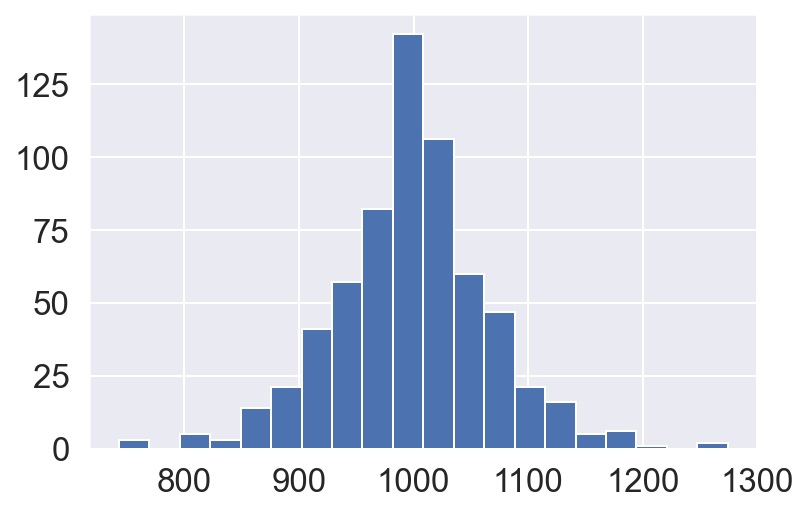

In [28]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [29]:
len(lengths)

632

In [30]:
chapters['translator'] = 'Jay Rubin'

In [31]:
chapters['book_title'] = 'Norwegian Wood'

In [32]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Book 1,"I was 37 then, strapped in my seat as the huge...","[115, 300, 320, 473, 569, 643, 734, 761, 794, ...","[868, 1999, 2992, 3970, 4862, 5962, 6988, 7972...","[I was 37 then, strapped in my seat as the hug...",Jay Rubin,Norwegian Wood
1,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74...","[924, 1926, 2925, 3997, 4861, 5754, 6924, 7914...","[m\n \nsf Thanks for your letter,\n wrote Naok...",Jay Rubin,Norwegian Wood


In [33]:
out_path = '../../../Documents/murakami/pkl2/'
out_name = 'nw_rubin_v01'
out_full_path = out_path + out_name + '.pkl'

In [34]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# read back pickle
with open (out_full_path, 'rb') as fp:
    read_nw = pickle.load(fp)

In [35]:
read_nw

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Book 1,"I was 37 then, strapped in my seat as the huge...","[115, 300, 320, 473, 569, 643, 734, 761, 794, ...","[868, 1999, 2992, 3970, 4862, 5962, 6988, 7972...","[I was 37 then, strapped in my seat as the hug...",Jay Rubin,Norwegian Wood
1,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74...","[924, 1926, 2925, 3997, 4861, 5754, 6924, 7914...","[m\n \nsf Thanks for your letter,\n wrote Naok...",Jay Rubin,Norwegian Wood
